In [14]:
from langchain_openai import OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain_community.document_loaders import UnstructuredHTMLLoader
from langchain.schema import Document

import os
import dotenv
import yaml

dotenv.load_dotenv()


True

# Self Rag

In [15]:
from rag.chroma import ChromaRetrievalChain
chroma = ChromaRetrievalChain(persist_directory="C:\\Users\\Sese\\AI_Study_Record\\RAG_AGENT\\rag_0628\\chroma_db").create_chain()


chroma_retriever = chroma.retriever
chroma_chain = chroma.chain

[DEBUG] Loading Chroma from: C:\Users\Sese\AI_Study_Record\RAG_AGENT\rag_0628\chroma_db
[DEBUG] Vectorstore collection size: 4865


In [16]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신모델 이름 설정
MODEL_NAME = get_model_name(LLMs.GPT4o)


# 데이터 모델 정의: 검색된 문서의 관련성을 이진 점수로 평가하기 위한 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved documents."""

    # 문서가 질문에 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 LLM의 구조화된 출력 생성
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의: 검색된 문서가 사용자 질문에 관련이 있는지 평가하는 시스템 역할 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 검색 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader

In [17]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# LangChain Hub에서 프롬프트 가져오기
prompt = hub.pull("teddynote/rag-prompt")

# 기본 LLM 초기화, 모델 이름과 온도 설정
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()


In [18]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델 정의: 생성된 답변이 사실에 기반하고 있는지 여부를 이진 점수로 평가하기 위한 데이터 모델
class Groundednesss(BaseModel):
    """A binary score indicating whether the generated answer is grounded in the facts."""

    # 답변이 사실에 기반하고 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 구조화된 출력과 함께 LLM 설정
structured_llm_grader = llm.with_structured_output(Groundednesss)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 채팅 프롬프트 템플릿 생성
groundedness_checking_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 답변의 할루시네이션 평가기 생성
groundedness_grader = groundedness_checking_prompt | structured_llm_grader

In [19]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class GradeAnswer(BaseModel):
    """A binary score indicating whether the question is addressed."""

    # 답변의 관련성 평가: 'yes' 또는 'no'로 표기(yes: 관련성 있음, no: 관련성 없음)
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# llm 에 GradeAnswer 바인딩
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 생성
answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 답변 평가기 생성
answer_grader = answer_grader_prompt | structured_llm_grader

In [20]:

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 시스템 프롬프트 정의
# 입력 질문을 벡터스토어 검색에 최적화된 형태로 변환하는 시스템 역할 정의
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 시스템 메시지와 초기 질문을 포함한 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# 질문 재작성기 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [21]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태를 나타내는 클래스 정의
class GraphState(TypedDict):
    # 질문을 나타내는 문자열
    question: Annotated[str, "Question"]
    # LLM에 의해 생성된 응답을 나타내는 문자열
    generation: Annotated[str, "LLM Generation"]
    # 문서의 목록을 나타내는 문자열 리스트
    documents: Annotated[List[str], "Retrieved Documents"]

In [22]:
# 문서 검색
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 검색 수행
    documents = chroma_retriever.invoke(question)
    # 🔍 문서 내용 출력
    print(f"🔎 Retrieved {len(documents)} documents:")
    for i, doc in enumerate(documents):
        print(f"\n--- Document {i+1} ---")
        print(doc.page_content.split('\n')[0])  # 너무 길 경우 앞 500자만 출력

    return {"documents": documents}



# 답변 생성
def generate(state):
    print("==== [GENERATE] ====")
    question = state["question"]
    documents = state["documents"]

    # RAG 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 검색된 문서의 관련성 평가
def grade_documents(state):
    print("==== [GRADE DOCUMENTS] ====")
    question = state["question"]
    documents = state["documents"]

    # 각 문서 점수 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("==== GRADE: DOCUMENT RELEVANT ====")
            filtered_docs.append(d)
        else:
            print("==== GRADE: DOCUMENT NOT RELEVANT ====")
            continue
    return {"documents": filtered_docs}


# 질문 변환
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}

In [23]:
# 답변 생성 여부 결정
def decide_to_generate(state):
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성이 없는 경우
        # 새로운 쿼리 생성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


# 생성된 답변의 문서 및 질문과의 관련성 평가
def grade_generation_v_documents_and_question(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = groundedness_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")
        # 질문 해결 여부 확인
        print("==== [GRADE GENERATION vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("==== [DECISION: GENERATION ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATION DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

In [24]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# 엣지 정의
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 엣지 정의
workflow.add_edge("transform_query", "retrieve")

# 답변 생성 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "relevant": END,
        "not relevant": "transform_query",
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

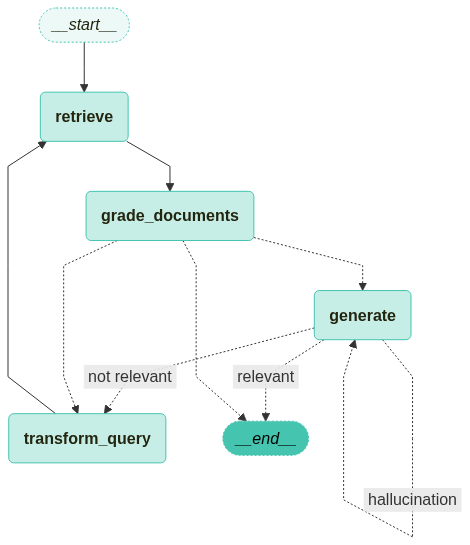

In [25]:

from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [1]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})



for question in [
"뎅기열과 비슷한 매개체로 인한 감염병은?",
"불명열 진단 순서를 설명하시오",
"패혈증의 정의와 치료 접근법은?",
"발열의 병태생리 설명하시오",
"Fever의 병태생리를 설명하시오.",
"심부전으로 입원한 환자의 초기 평가 항목은?",
"심부전으로 입원한 환자에게 처음 시행해야 할 처치는?",
"급성 심부전으로 입원한 환자에게 처음 시행해야 할 처치는?",
]:
    print('\n\n\n' + '=' * 50)
    print('=' * 50)
    # 질문 입력
    inputs = {
        "question": question,
    }

    # 그래프 실행
    invoke_graph(
        app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
    )

NameError: name 'app' is not defined

In [27]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})



for question in [
"뎅기열과 비슷한 매개체로 인한 감염병은?",
"불명열 진단 순서를 설명하시오",
"패혈증의 정의와 치료 접근법은?",
"발열의 병태생리 설명하시오",
"Fever의 병태생리를 설명하시오.",
"심부전으로 입원한 환자의 초기 평가 항목은?",
"심부전으로 입원한 환자에게 처음 시행해야 할 처치는?",
"급성 심부전으로 입원한 환자에게 처음 시행해야 할 처치는?",
]:
    print('\n\n\n' + '=' * 50)
    print('=' * 50)
    # 질문 입력
    inputs = {
        "question": question,
    }

    # 그래프 실행
    invoke_graph(
        app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
    )




==== [RETRIEVE] ====
🔎 Retrieved 10 documents:

--- Document 1 ---
제목: Leptospira interrogans

--- Document 2 ---
제목: Vibrio spp.

--- Document 3 ---
제목: 요로감염

--- Document 4 ---
제목: 염증의 양상

--- Document 5 ---
제목: Pseudomonas aeruginosa

--- Document 6 ---
제목: 모기 매개 감염병

--- Document 7 ---
제목: 여행 관련 바이러스 감염

--- Document 8 ---
제목: 녹농균 감염

--- Document 9 ---
제목: 위식도역류질환

--- Document 10 ---
제목: 발열, 불명열

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='제목: Leptospira interrogans

2. 감염 
 1) 감염된 동물, 특히 들쥐의 소변을 통해 주로 전염된다. 해당 균에 감염된 동물의 소변이 물이나 토양에 오염되고, 여기에 점막이나 상처가 닿으면 감염된다. 소변에 직접 접촉하거나 비말을 흡입, 오염된 음식을 먹어도 걸릴 수 있다. 
 2) 우리나라에서  농촌과 남부 지역 에 많으며, 8월 초에서 11월 사이의  가을 에,  20~40대의 활동기 성인 남자 에게서 호발한다. 따라서 추수, 성묘, 훈련 등의 병력을 가진 환자가 많다. 또한 농부, 수의사, 하수도 노동자, 야외활동자 등에서 직업적 노출이 일어나는 것도 고려해야한다. 
 
 해당 균에 의해 생기는 질병을  Leptospirosis 라 하며, 중증 감염의 경우 Weil’s Disease라 부르기도 한다. 
 
 
 항목 
 Leptospirosis 
 Weil’s Disease 
 
 
 정의 
 Leptospira interrogans 감염에 의한 전신성 감염 질환 


In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})



for question in [
"뎅기열과 비슷한 매개체로 인한 감염병은?",
"불명열 진단 순서를 설명하시오",
"패혈증의 정의와 치료 접근법은?",
"발열의 병태생리 설명하시오",
"Fever의 병태생리를 설명하시오.",
"심부전으로 입원한 환자의 초기 평가 항목은?",
"심부전으로 입원한 환자에게 처음 시행해야 할 처치는?",
"급성 심부전으로 입원한 환자에게 처음 시행해야 할 처치는?",
]:
    print('\n\n\n' + '=' * 50)
    print('=' * 50)
    # 질문 입력
    inputs = {
        "question": question,
    }

    # 그래프 실행
    invoke_graph(
        app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
    )